In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
from scipy import stats

In [2]:
import seaborn as sns

### example ts data

In [3]:
df = sns.load_dataset("taxis")
print(f"{df.shape}")
df.head(1)

(6433, 14)


,pickup,dropoff,passengers,distance,fare,tip,tolls,total,color,payment,pickup_zone,dropoff_zone,pickup_borough,dropoff_borough
0,2019-03-23 20:21:09,2019-03-23 20:27:24,1,1.6,7.0,2.15,0.0,12.95,yellow,credit card,Lenox Hill West,UN/Turtle Bay South,Manhattan,Manhattan


In [4]:
df["pickup_date"] = df["pickup"].dt.date
df["pickup_week"] = (
    pd.to_datetime(df["pickup"]).dt.to_period("W").dt.to_timestamp().dt.date
)

In [15]:
print(f"{df.shape}")
df.head(1)

(6433, 16)


,pickup,dropoff,passengers,distance,fare,tip,tolls,total,color,payment,pickup_zone,dropoff_zone,pickup_borough,dropoff_borough,pickup_date,pickup_week
0,2019-03-23 20:21:09,2019-03-23 20:27:24,1,1.6,7.0,2.15,0.0,12.95,yellow,credit card,Lenox Hill West,UN/Turtle Bay South,Manhattan,Manhattan,2019-03-23,2019-03-18


In [69]:
pdf = df.groupby(["pickup_week", "pickup_borough"]).agg(
    tip_amount=("tip", "sum"),
    fare_amount=("fare", "sum"),
    n=("tip", "count"),
)

In [18]:
pdf

tip_amount  fare_amount     n
pickup_week pickup_borough                               
2019-02-25  Bronx                 2.36       185.15    10
            Brooklyn             51.95       775.62    49
            Manhattan           936.21      5327.50   493
            Queens               89.14      1197.09    54
2019-03-04  Bronx                 2.00       568.17    22
            Brooklyn             67.08      1738.63    90
            Manhattan          2341.79     13625.14  1230
            Queens              491.51      3790.58   151
2019-03-11  Bronx                10.35       363.10    17
            Brooklyn             90.93      1555.61    93
            Manhattan          2481.83     14458.24  1262
            Queens              488.12      3954.70   154
2019-03-18  Bronx                 0.00       474.36    27
            Brooklyn             64.32      1081.83    78
            Manhattan          2252.69     13009.74  1154
            Queens              428.46      3784.82   147
2019-03-25  Bronx                 0.00       488.13    23
            Brooklyn             95.83      1175.79    73
            Manhattan          2205.03     12332.80  1129
            Queens              500.09      3654.87   151

## Line charts

Text(0.5, 1.0, 'Total number of trips')

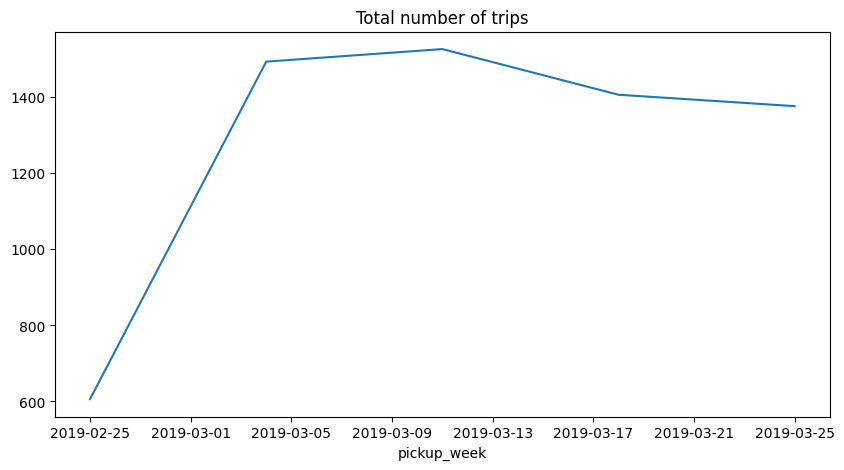

In [26]:
# overall volume
fig, ax = plt.subplots(figsize=(10, 5))
pdf.groupby("pickup_week").sum()["n"].plot(ax=ax)
ax.set_title("Total number of trips")

Text(0.5, 1.0, 'n')

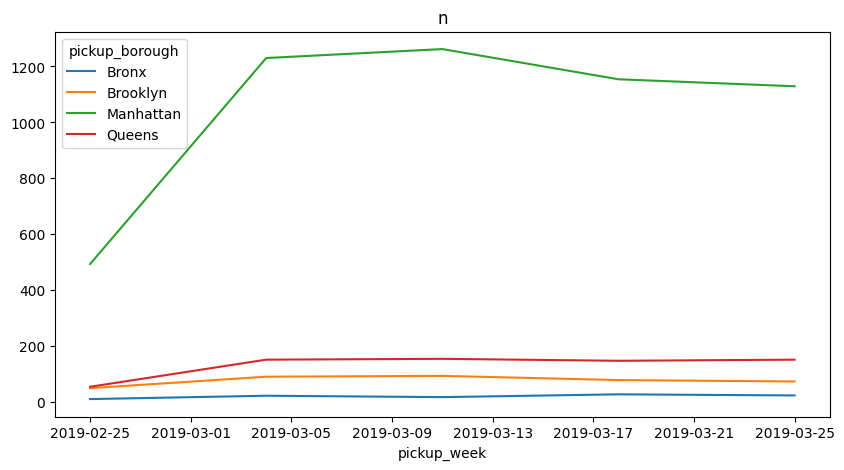

In [29]:
# volume by borough
fig, ax = plt.subplots(figsize=(10, 5))
pdf["n"].unstack().plot(ax=ax)
ax.set_title("n")

Text(0.5, 1.0, 'n')

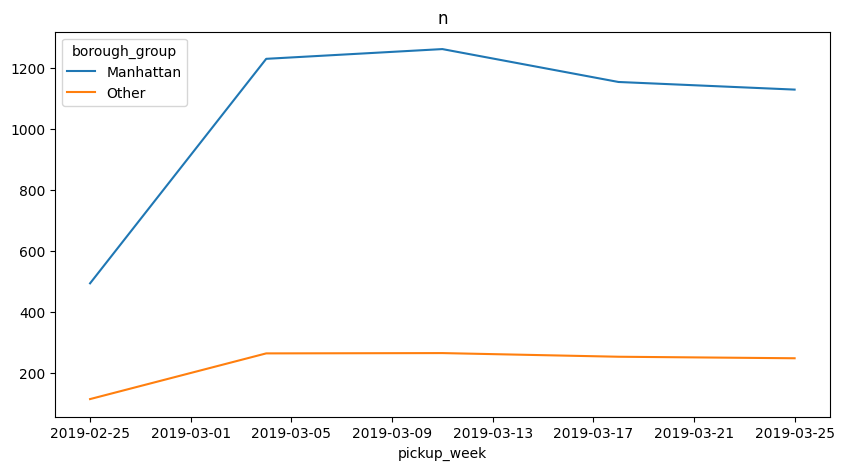

In [32]:
# volume by borough groups: manhattan, and others
pdf["borough_group"] = np.where(
    pdf.index.get_level_values("pickup_borough") == "Manhattan", "Manhattan", "Other"
)
pdf2 = pdf.groupby(["pickup_week", "borough_group"]).sum()

fig, ax = plt.subplots(figsize=(10, 5))
pdf2["n"].unstack().plot(ax=ax)
ax.set_title("n")

In [35]:
# pivot table colour-coded
pdf2 = pdf.pivot_table(
    index="pickup_week", columns="pickup_borough", values="n", aggfunc="sum"
)
pdf2.style.background_gradient(cmap="RdYlGn")

pickup_borough,Bronx,Brooklyn,Manhattan,Queens
pickup_week,,,,
2019-02-25,10,49,493,54
2019-03-04,22,90,1230,151
2019-03-11,17,93,1262,154
2019-03-18,27,78,1154,147
2019-03-25,23,73,1129,151


In [47]:
# pivot table colour-coded
pdf2 = (
    pdf.pivot_table(
        index="pickup_week", columns="pickup_borough", values="n", aggfunc="sum"
    )
    .div(pdf.groupby("pickup_week")["n"].sum(), axis=0)
    .mul(100)
    .round(2)
)
pdf2.style.background_gradient(cmap="RdYlGn", axis=1).format("{:.2f}%")

pickup_borough,Bronx,Brooklyn,Manhattan,Queens
pickup_week,,,,
2019-02-25,1.65%,8.09%,81.35%,8.91%
2019-03-04,1.47%,6.03%,82.38%,10.11%
2019-03-11,1.11%,6.09%,82.70%,10.09%
2019-03-18,1.92%,5.55%,82.08%,10.46%
2019-03-25,1.67%,5.31%,82.05%,10.97%


In [70]:
# make sequencial dummy for boroughs
pdf["borough_rank"] = pdf.index.get_level_values("pickup_borough").map(
    {"Manhattan": 1, "Brooklyn": 2, "Queens": 3, "Bronx": 4, "Staten Island": 5}
)
pdf

tip_amount  fare_amount     n  borough_rank
pickup_week pickup_borough                                             
2019-02-25  Bronx                 2.36       185.15    10             4
            Brooklyn             51.95       775.62    49             2
            Manhattan           936.21     5,327.50   493             1
            Queens               89.14     1,197.09    54             3
2019-03-04  Bronx                 2.00       568.17    22             4
            Brooklyn             67.08     1,738.63    90             2
            Manhattan         2,341.79    13,625.14  1230             1
            Queens              491.51     3,790.58   151             3
2019-03-11  Bronx                10.35       363.10    17             4
            Brooklyn             90.93     1,555.61    93             2
            Manhattan         2,481.83    14,458.24  1262             1
            Queens              488.12     3,954.70   154             3
2019-03-18  Bronx                 0.00       474.36    27             4
            Brooklyn             64.32     1,081.83    78             2
            Manhattan         2,252.69    13,009.74  1154             1
            Queens              428.46     3,784.82   147             3
2019-03-25  Bronx                 0.00       488.13    23             4
            Brooklyn             95.83     1,175.79    73             2
            Manhattan         2,205.03    12,332.80  1129             1
            Queens              500.09     3,654.87   151             3

In [125]:
# make into 2 vectors
x = pdf.loc[(pd.to_datetime("2019-02-25").date(),), ["n", "borough_rank"]].to_numpy().T
counts = x[0]
ranks = x[1]

In [122]:
counts

array([ 10,  49, 493,  54], dtype=int64)

In [126]:
ranks

array([4, 2, 1, 3], dtype=int64)

In [127]:
# median of counts, accounting into ranks, if they were full dataset insead of counts and ranks
np.median(np.repeat(ranks, counts))

21.25

In [129]:
rpt = np.repeat(ranks, counts)
rpt.

array([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [50]:
pdf

tip_amount  fare_amount     n borough_group
pickup_week pickup_borough                                             
2019-02-25  Bronx                 2.36       185.15    10         Other
            Brooklyn             51.95       775.62    49         Other
            Manhattan           936.21     5,327.50   493     Manhattan
            Queens               89.14     1,197.09    54         Other
2019-03-04  Bronx                 2.00       568.17    22         Other
            Brooklyn             67.08     1,738.63    90         Other
            Manhattan         2,341.79    13,625.14  1230     Manhattan
            Queens              491.51     3,790.58   151         Other
2019-03-11  Bronx                10.35       363.10    17         Other
            Brooklyn             90.93     1,555.61    93         Other
            Manhattan         2,481.83    14,458.24  1262     Manhattan
            Queens              488.12     3,954.70   154         Other
2019-03-18  Bronx                 0.00       474.36    27         Other
            Brooklyn             64.32     1,081.83    78         Other
            Manhattan         2,252.69    13,009.74  1154     Manhattan
            Queens              428.46     3,784.82   147         Other
2019-03-25  Bronx                 0.00       488.13    23         Other
            Brooklyn             95.83     1,175.79    73         Other
            Manhattan         2,205.03    12,332.80  1129     Manhattan
            Queens              500.09     3,654.87   151         Other